# DSCI 100 Group 30 Project Proposal

# Classification of User Knowledge  

## Introduction

Electrical DC machines are electro-mechanical energy conversion devices that consist of a motor that takes in electrical power through a direct electric current and converts this energy into mechanical rotational energy. Depending on the size and power of the DC motor, the mechanical energy can then be used to power everything from heavy, industrial machinery to everyday tools and appliances. The understanding and application of electrical DC machines play a crucial role in the development of many everyday objects we use.

Our group will be using the “User Knowledge Modeling Data Set” to answer the predictive question: **What is the knowledge level of a user studying Electrical DC Machines?** The dataset is from a Ph.D. thesis that looked at the development of an intuitive knowledge classifier method for modelling a set of domain-dependent data about students’ knowledge status of Electrical DC Machines. The dataset comprises six variables: 
* STG (degree of study time for goal object materials)
* SCG (degree of repetition number of user for goal object materials)
* STR (degree of study time of user for related objects with goal object)
* LPR (exam performance of user for related objects with goal object)
* PEG (exam performance of user for goal objects)
* UNS (knowledge level of user)

UNS will be the variable to predict in our model.

## Preliminary exploratory data analysis

In [1]:
library(tidyverse)
library(readxl)
library(digest)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

### Reading the file from the web

The `read_excel` function cannot directly read URL paths, so we first downloaded the file from the web then used `read_excel`.

The original dataset was already split into training and testing datasets in 2 different excel sheets. Since we want to perform our own classification, we will merge these data frames and split into training and testing sets oursevles.

In [2]:
# Code to download file from: https://stackoverflow.com/questions/60656958/how-do-i-read-excel-file-through-url-in-r-studio-its-https
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls",destfile="knowledge.xls")
knowledge_raw_training <- read_excel('knowledge.xls', sheet = 2, range = "A1:F259")
knowledge_raw_testing <- read_excel('knowledge.xls', sheet = 3, range = "A1:F146")

# Code to combine the dataframes from: https://www.statmethods.net/management/merging.html
knowledge_data <- rbind(knowledge_raw_training, knowledge_raw_testing)
knowledge_data

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
⋮,⋮,⋮,⋮,⋮,⋮
0.56,0.60,0.77,0.13,0.32,Low
0.66,0.68,0.81,0.57,0.57,Middle
0.68,0.64,0.79,0.97,0.24,Middle


### Cleaning and wrangling the dataset

The raw dataset seems to be clean - each column is a variable, each row is an observation and each cell is a distinct value. Since the type of the variable to predict (`UNS`, the user's knowledge level) is currently a character, we'll make it a factor with `as_factor()`.

In [3]:
knowledge_data <- knowledge_data %>%
                    mutate(UNS = as_factor(UNS))

knowledge_data

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
⋮,⋮,⋮,⋮,⋮,⋮
0.56,0.60,0.77,0.13,0.32,Low
0.66,0.68,0.81,0.57,0.57,Middle
0.68,0.64,0.79,0.97,0.24,Middle


Now, we will split 75% of the data into a training set and the remaining 25% will form the testing set.

In [4]:
# Code adapted from Chapter 6 of the course textbook
set.seed(1)
knowledge_split <- initial_split(knowledge_data, prop = 0.75, strata = UNS)
knowledge_training <- training(knowledge_split)
knowledge_testing <- testing(knowledge_split)

glimpse(knowledge_training)

Rows: 303
Columns: 6
$ STG <dbl> 0.00, 0.06, 0.08, 0.09, 0.10, 0.15, 0.20, 0.00, 0.18, 0.06, 0.10,…
$ SCG <dbl> 0.000, 0.060, 0.080, 0.150, 0.100, 0.020, 0.140, 0.000, 0.180, 0.…
$ STR <dbl> 0.00, 0.05, 0.08, 0.40, 0.43, 0.34, 0.35, 0.50, 0.55, 0.51, 0.52,…
$ LPR <dbl> 0.00, 0.25, 0.98, 0.10, 0.29, 0.40, 0.72, 0.20, 0.30, 0.41, 0.78,…
$ PEG <dbl> 0.00, 0.33, 0.24, 0.66, 0.56, 0.01, 0.25, 0.85, 0.81, 0.30, 0.34,…
$ UNS <fct> very_low, Low, Low, Middle, Middle, very_low, Low, High, High, Lo…


### Data exploration

There are 4 levels of the user knowledge level (UNS) variable - very low, low, middle and high. The table below summarizes the number and percentage of observations in the training set in each level.

In [5]:
# Code adapted from Chapter 5 of course textbook

num_obs <- nrow(knowledge_training)

knowledge_training %>%
    group_by(UNS) %>%
    summarize(count = n(), percentage = n()/num_obs *100)

`summarise()` ungrouping output (override with `.groups` argument)



UNS,count,percentage
<fct>,<int>,<dbl>
very_low,17,5.610561
High,75,24.752475
Low,97,32.013201
Middle,94,31.023102
Very Low,20,6.600660


The table below shows the mean values of all the predictor variables in the training set.

In [6]:
knowledge_training %>% 
    select(STG, SCG) %>%
    map_df(mean)

STG,SCG
<dbl>,<dbl>
0.3572178,0.3618119


There are no missing values in the training dataset as shown below.

In [7]:
rows_missing_vals <- sum(is.na(knowledge_training))
rows_missing_vals

[1] 0

### Data visualization

Below are histograms for the distribution of each predictor variable in the training data set.

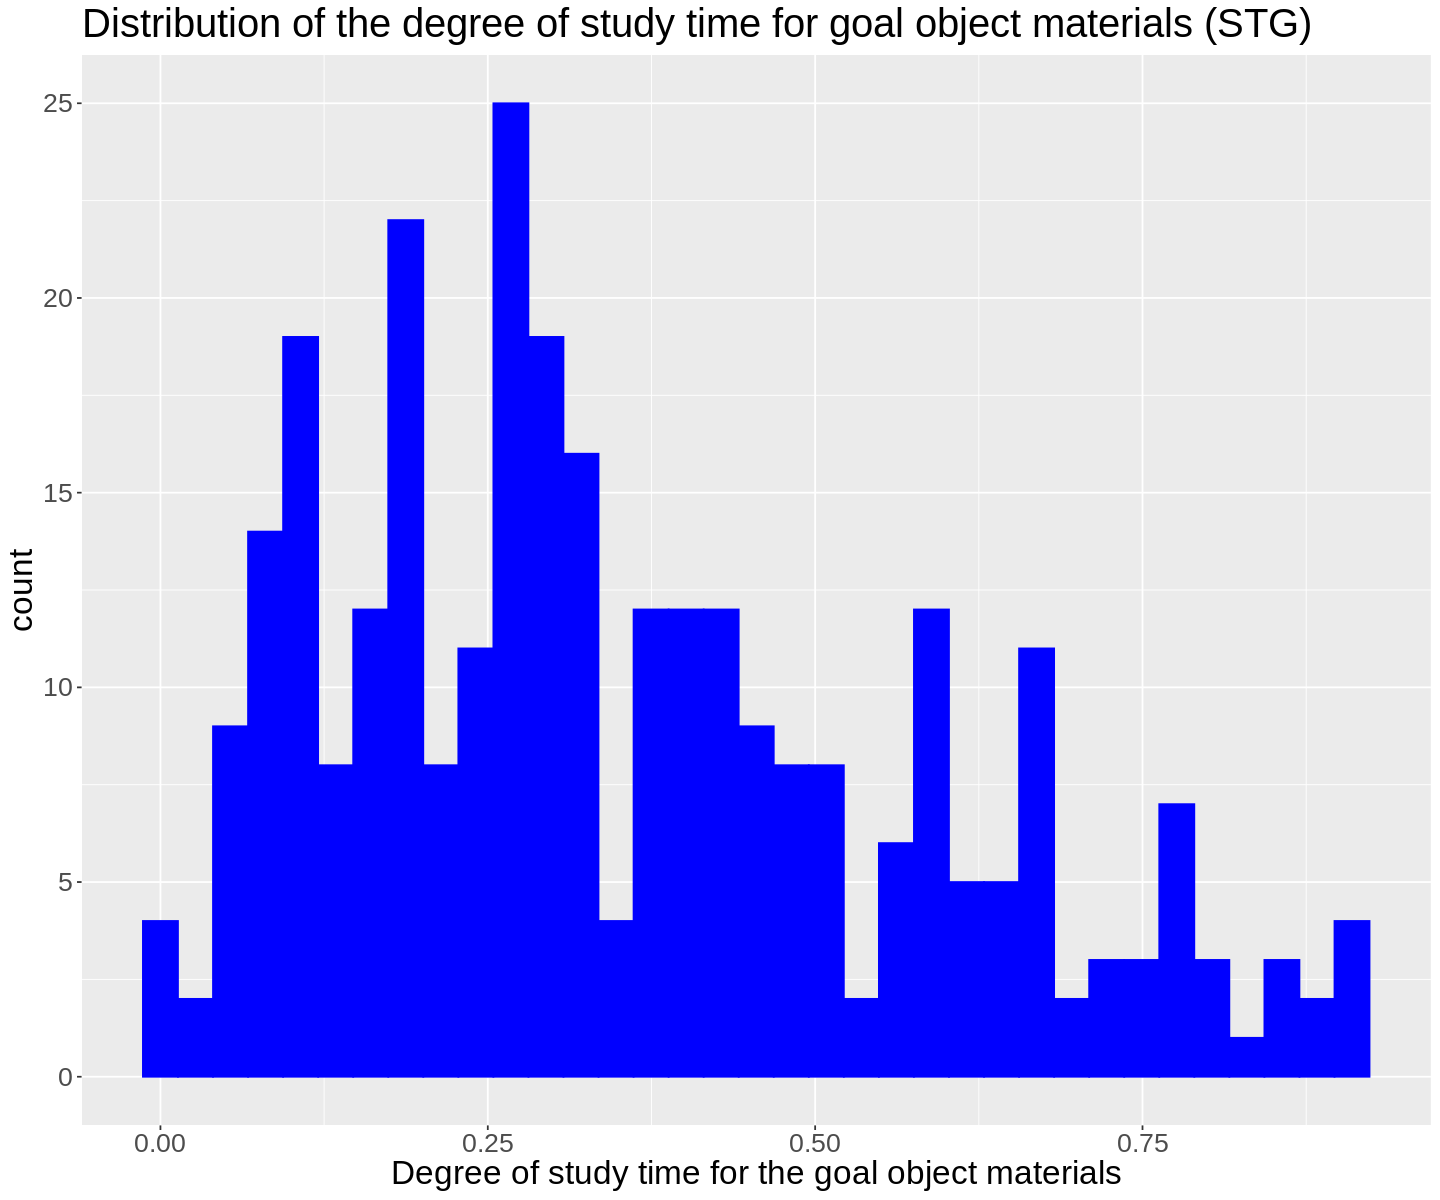

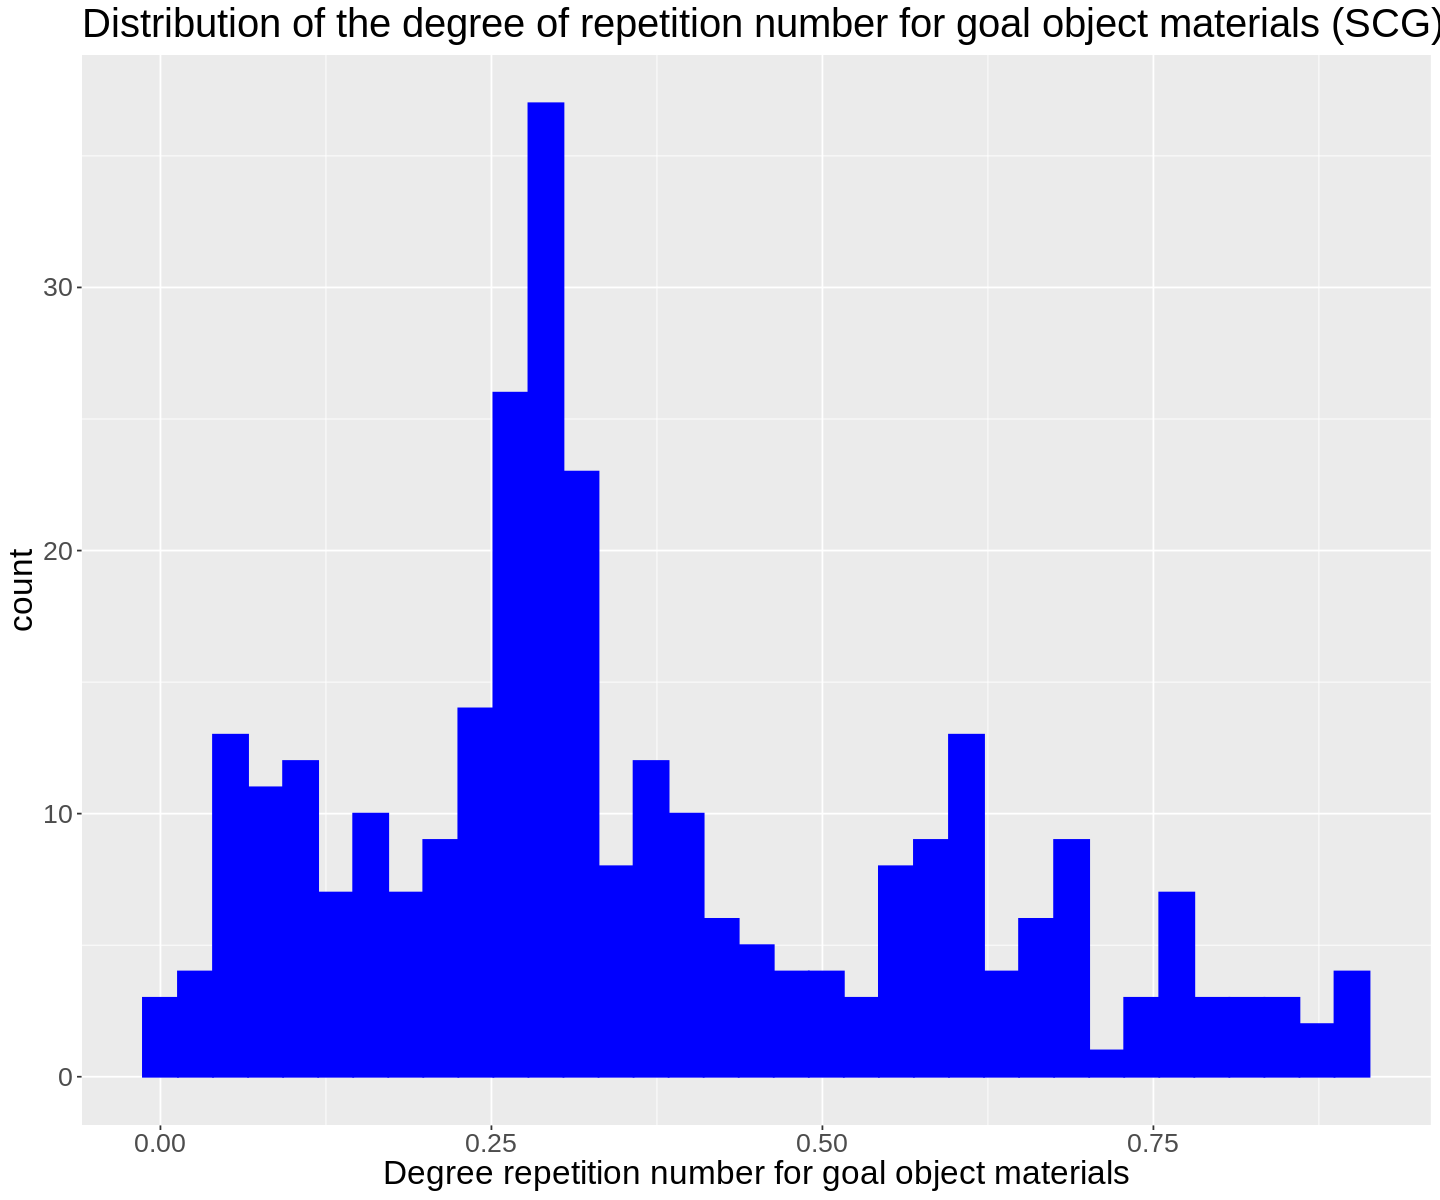

In [13]:
options(repr.plot.width = 12, repr.plot.height = 10)

stg_hist <- ggplot(knowledge_training, aes(x = STG)) +
            geom_histogram(bins = 35, color = "blue", fill = "blue") + 
            ggtitle("Distribution of the degree of study time for goal object materials (STG)") + 
            xlab("Degree of study time for the goal object materials") + 
            theme(text = element_text(size = 20))  

scg_hist <- ggplot(knowledge_training, aes(x = SCG)) +
            geom_histogram(bins = 35, color = "blue", fill = "blue") + 
            ggtitle("Distribution of the degree of repetition number for goal object materials (SCG)") + 
            xlab("Degree repetition number for goal object materials") + 
            theme(text = element_text(size = 20))

stg_hist
scg_hist

## Methods

We plan to use **`STG` (degree of study time for goal object materials)** and **`SCG` (degree of repetition number of user for goal object materials)** as predictor variables. We think that these will be useful for prediction because intuitively, the strength of practice (time and repetition) should have a meaningful positive relationship with a user's knowledge level.

Steps in our data analysis (K-nearest neighbors):
1. Store `STG`, `SCG` and `UNS` as a new data set. Standardize the data with `tidymodels`.
2. Use `tidymodels` to train our classifier with K = 5 initially. This involves making a model specification and using `fit` with the training set.
3. Predict the labels in the test set with our classifier.
3. Evaluate our classifier according to accuracy, the confusion matrix and the majority classifier.
4. Tune the classifier via 5-fold and 10-fold cross-validation and validation sets, using `tidymodels`'s `vfold_cv`, `fit_resamples` and `collect_metrics()`. Lastly select C = 5 or 10, whichever has a lower standard error.

Visualization of results: 
- a scatterplot of `STG` vs. `SCG` with points colored to `UNS`
- a scatterplot of accuracy vs. K to decide which K is best

## Expected outcomes and significance

From the question proposed and the brief exploratory data analysis conducted, we expect to find that people who spend more time in school have a higher knowledge level and have higher scores for their exam performance. The impact of these findings could show the necessity of schooling in the field. The outcomes of this project could lead to future questions about the relation between knowledge and the specific program or school that each of the participants is a part of. This could be used to improve the quality of schooling although it would consist of collecting a new set of data since the current data set does not contain this information. 